New logic: Swire would want to predict the abandonment couple of days before the end of the window. 
Fit training data with cart abandonment but only up to the last 2 windows of puchase or abandon. 
Then for the test data, test/predict only couples days in not wait untill the end of the window. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


# from lightgbm import LGBMClassifier
# import xgboost as xgb
# from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns


# Clean google analytics.csv and join with customer.csv 


In [2]:
ga = pd.read_csv("Copy of google_analytics.csv")
pd.set_option('display.max_columns', None)
ga.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS
0,501508595,2025-04-07,2025-04-07T14:57:40.713Z,view_search_results,mobile,Samsung,Android,Product List,NaN,[]
1,501730915,2025-04-07,2025-04-07T19:28:54.546Z,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id..."
2,501567329,2025-04-07,2025-04-07T21:40:56.281Z,purchase,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,"[{""item_id"":""138335"",""quantity"":""2""},{""item_id..."
3,501765083,2025-04-08,2025-04-08T06:06:36.717Z,user_engagement,mobile,Apple,iOS,NaN,NaN,[]
4,501707837,2025-04-08,2025-04-08T18:12:10.511Z,view_item_list,desktop,Google,Windows,MyCoke Orders,Category: All Products,"[{""item_id"":""412588"",""quantity"":""1""},{""item_id..."


In [3]:
# Getting only cart affected events
ga_cart_events = ga[ga['EVENT_NAME'].isin(['add_to_cart', 'remove_from_cart','purchase'])]

In [4]:
# Join customer.csv with ga_cart_events to get customer's local time 
customer = pd.read_csv('Copy of customer.csv')

customer_ga_cart_events = pd.merge(ga_cart_events, customer, left_on='CUSTOMER_ID', right_on='CUSTOMER_NUMBER', how='left')

In [5]:
from zoneinfo import ZoneInfo
import pandas as pd

# ---- 1) City → timezone map (as you had) ----
city_tz = {
    "Tacoma, WA":"America/Los_Angeles","Spokane, WA":"America/Los_Angeles",
    "Arlington, WA":"America/Los_Angeles","Bellevue, WA":"America/Los_Angeles",
    "Walla Walla, WA":"America/Los_Angeles","Reno, NV":"America/Los_Angeles",
    "Elko, NV":"America/Los_Angeles","Pendleton, OR":"America/Los_Angeles",
    "Eugene, OR":"America/Los_Angeles","Wilsonville, OR":"America/Los_Angeles",
    "Bend, OR":"America/Los_Angeles","LaGrande, OR":"America/Los_Angeles",
    "Lewiston, ID":"America/Los_Angeles","Wenatchee, WA":"America/Los_Angeles",
    "Bremerton, WA":"America/Los_Angeles",
    "Denver, CO":"America/Denver","Colorado Springs, CO":"America/Denver",
    "Grand Junction, CO":"America/Denver","Glenwood Springs, CO":"America/Denver",
    "Pueblo, CO":"America/Denver","Alamosa, CO":"America/Denver",
    "Johnstown, CO":"America/Denver","Cheyenne, WY":"America/Denver",
    "Richfield, UT":"America/Denver","Draper, UT":"America/Denver",
    "Logan, UT":"America/Denver","Ogden, UT":"America/Denver",
    "Price, UT":"America/Denver","Albuquerque, NM":"America/Denver",
    "Scottsbluff, NE":"America/Denver",
    "Boise, ID":"America/Boise","Idaho Falls, ID":"America/Boise","Pocatello, ID":"America/Boise",
    "Tempe, AZ":"America/Phoenix","Tucson, AZ":"America/Phoenix",
    "Prescott, AZ":"America/Phoenix","Glendale, AZ":"America/Phoenix",
    "Kingman, AZ":"America/Phoenix","Huachuca City, AZ":"America/Phoenix",
    "Show Low, AZ":"America/Phoenix","Flagstaff, AZ":"America/Phoenix",
    "Yuma, AZ":"America/Phoenix",
}

# ---- 2) Parse timestamp as UTC (kept your column name) ----
customer_ga_cart_events["EVENT_TIMESTAMP_UTC"] = pd.to_datetime(
    customer_ga_cart_events["EVENT_TIMESTAMP"], utc=True, errors="coerce"
)

# ---- 3) Map timezone from CITY (use CITY consistently) ----
customer_ga_cart_events["TIMEZONE"] = customer_ga_cart_events["SALES_OFFICE_DESCRIPTION"].map(city_tz)

# ---- 4) Convert to local datetime per-row (only when TIMEZONE present) ----
customer_ga_cart_events["EVENT_LOCAL_DT"] = customer_ga_cart_events.apply(
    lambda row: (
        row["EVENT_TIMESTAMP_UTC"].astimezone(ZoneInfo(row["TIMEZONE"]))
        if pd.notna(row["TIMEZONE"]) and pd.notna(row["EVENT_TIMESTAMP_UTC"])
        else pd.NaT
    ),
    axis=1
)

# ---- 5) Convenience columns: date / hour / day-of-week ----
customer_ga_cart_events["EVENT_LOCAL_DATE"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.date() if pd.notna(v) else pd.NaT
)
customer_ga_cart_events["EVENT_LOCAL_TIME"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.strftime("%I:%M:%S %p") if pd.notna(v) else pd.NA
)
customer_ga_cart_events["EVENT_LOCAL_DOW"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.day_name() if pd.notna(v) else pd.NA
)

# ---- 6) Drop duplicates (use the actual UTC column name) ----
customer_ga_cart_events = customer_ga_cart_events.drop_duplicates(
    subset=["CUSTOMER_ID","EVENT_TIMESTAMP_UTC","EVENT_NAME"],
    keep="first"
)

# ---- 7) Select relevant columns (use consistent names) ----
cols = [
    "CUSTOMER_ID","CITY","TIMEZONE","EVENT_NAME",
    "EVENT_LOCAL_TIME","EVENT_LOCAL_DT","EVENT_LOCAL_DATE",
    "EVENT_LOCAL_HOUR","EVENT_LOCAL_DOW",
    "DEVICE_CATEGORY","DEVICE_MOBILE_BRAND_NAME","DEVICE_OPERATING_SYSTEM",
    "EVENT_PAGE_NAME","EVENT_PAGE_TITLE"
]
existing_cols = [c for c in cols if c in customer_ga_cart_events.columns]
customer_ga_cart_events = customer_ga_cart_events[existing_cols]

customer_ga_cart_events.head()


,CUSTOMER_ID,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE
0,501567329,America/Los_Angeles,purchase,02:40:56 PM,2025-04-07 14:40:56.281000-07:00,2025-04-07,Monday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order
1,501702910,America/Denver,add_to_cart,12:30:14 PM,2025-05-24 12:30:14.025000-06:00,2025-05-24,Saturday,desktop,Google,Windows,NaN,Search
2,501565777,America/Phoenix,add_to_cart,01:08:07 PM,2025-05-20 13:08:07.167000-07:00,2025-05-20,Tuesday,mobile,Samsung,Android,NaN,Search
3,501752380,America/Los_Angeles,add_to_cart,02:25:29 PM,2025-05-16 14:25:29.494000-07:00,2025-05-16,Friday,desktop,Apple,Macintosh,NaN,Search
4,500549947,America/Los_Angeles,add_to_cart,06:12:45 PM,2025-04-07 18:12:45.609000-07:00,2025-04-07,Monday,mobile,Apple,iOS,Product List,NaN


# The windows from master.csv

check between purchaes from order and purchase from GA, check how much missing is there. Finlay's table is already in windows format, can't use this because of new logic. 

In [6]:
windows = pd.read_csv('new_master.csv')

In [7]:
#Make name clear
windows['ORDER_CREATED_DATE_UTC'] = windows['CREATED_DATE_UTC']


#Drop leakage columns and column from GA adding later
windows = windows.drop(columns=['num_add_to_cart_events','total_items_added_to_cart',
                                'purchases','button_clicks','total_events','DISTRIBUTION_MODE',
                                'SALES_OFFICE_DESC','CREATED_DATE_EST','CREATED_DATE_UTC',
                                'ORDER_QUANTITY','ORDER_TYPE','MATERIAL_LIST'])



In [8]:
pd.set_option('display.max_columns', None)

windows.head(20)

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,ABANDONED_CART,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC
0,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
1,500245685,2025-03-17,2025-03-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
2,500245685,2025-04-14,2025-04-21,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
3,500245685,2025-04-28,2025-05-05,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
4,500245738,2024-11-20,2024-11-27,0,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-11-22 18:46:16+00:00
5,500245738,2024-11-27,2024-12-04,0,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-11-28 02:46:16+00:00
6,500245738,2024-12-04,2024-12-11,0,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-12-04 22:02:03+00:00
7,500245738,2024-12-11,2024-12-18,0,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-12-13 01:44:02+00:00
8,500245738,2024-12-18,2024-12-25,0,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-12-23 22:36:08+00:00
9,500245738,2025-01-08,2025-01-15,0,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2025-01-08 19:21:06+00:00


# windows join customer_ga_cart_events

Join exploded windows to Google Analytics, with cart events only.

Left merge from windows and filter for correct dates of GA within windows. 

In [9]:
# Ensure datetime types
windows["ANCHOR_DATE"] = pd.to_datetime(windows["ANCHOR_DATE"])
windows["NEXT_ANCHOR_SAME_WD"] = pd.to_datetime(windows["NEXT_ANCHOR_SAME_WD"])
customer_ga_cart_events["EVENT_LOCAL_DATE"] = pd.to_datetime(customer_ga_cart_events["EVENT_LOCAL_DATE"])

# Perform a LEFT merge (windows = left table)
windows_with_ga = pd.merge(
    windows,
    customer_ga_cart_events,
    on="CUSTOMER_ID",
    how="left"
)


windows_with_ga["WINDOW_START_LOCAL"] = pd.to_datetime(
    windows_with_ga["ANCHOR_DATE"].dt.strftime("%Y-%m-%d") + " " + windows_with_ga['CUTOFFTIME__C'],   #CUTOFFTIME__C	?
    errors="coerce"
)
windows_with_ga["WINDOW_END_LOCAL"] = pd.to_datetime(
    windows_with_ga["NEXT_ANCHOR_SAME_WD"].dt.strftime("%Y-%m-%d") + " " + windows_with_ga['CUTOFFTIME__C'],
    errors="coerce"
)

# 2) Drop timezone from the event’s local datetime so it’s naive too
windows_with_ga["EVENT_LOCAL_NAIVE"] = windows_with_ga["EVENT_LOCAL_DT"].apply(
    lambda v: pd.NaT if pd.isna(v) else pd.Timestamp(v).tz_localize(None)
)

# 1) Build in-window mask (compare naive-to-naive)
in_window = (
    (windows_with_ga["EVENT_LOCAL_NAIVE"] >= windows_with_ga["WINDOW_START_LOCAL"]) &
    (windows_with_ga["EVENT_LOCAL_NAIVE"] <  windows_with_ga["WINDOW_END_LOCAL"])
)

# Turn ORDER_CREATED_DATE_UTC to local time 
windows_with_ga['ORDER_CREATED_DATE_UTC'] = pd.to_datetime(
    windows_with_ga['ORDER_CREATED_DATE_UTC'], utc=True, errors="coerce"
    ) 

windows_with_ga['ORDER_CREATED_DATE_LOCAL'] = windows_with_ga.apply(
    lambda row: (
        row["ORDER_CREATED_DATE_UTC"].astimezone(ZoneInfo(row["TIMEZONE"]))
        if pd.notna(row["TIMEZONE"]) and pd.notna(row["ORDER_CREATED_DATE_UTC"])
        else pd.NaT
    ),
    axis=1
)

windows_with_ga = windows_with_ga[in_window].copy()





/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_47573/2625391076.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  windows_with_ga["WINDOW_START_LOCAL"] = pd.to_datetime(
/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_47573/2625391076.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  windows_with_ga["WINDOW_END_LOCAL"] = pd.to_datetime(


This is all the GA cart events for each windows. Each windows migh have many events (unaggreagated)

In [10]:
windows_with_ga[windows_with_ga['CUSTOMER_ID']==501730915].head()

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,ABANDONED_CART,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,ORDER_CREATED_DATE_LOCAL
1721073,501730915,2024-11-14,2024-11-21,0,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:47:12 AM,2024-11-18 08:47:12.263000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,NaN,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:47:12.263,2024-11-18 09:01:15-07:00
1721075,501730915,2024-11-14,2024-11-21,0,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:49:59 AM,2024-11-18 08:49:59.113000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:49:59.113,2024-11-18 09:01:15-07:00
1721079,501730915,2024-11-14,2024-11-21,0,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:47:45 AM,2024-11-18 08:47:45.663000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,NaN,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:47:45.663,2024-11-18 09:01:15-07:00
1721087,501730915,2024-11-14,2024-11-21,0,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:54:16 AM,2024-11-18 08:54:16.470000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:54:16.470,2024-11-18 09:01:15-07:00
1721097,501730915,2024-11-14,2024-11-21,0,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,purchase,08:56:09 AM,2024-11-18 08:56:09.930000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Order,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:56:09.930,2024-11-18 09:01:15-07:00


# New logic for GA cutoff date

In [11]:
windows_with_ga1=windows_with_ga.copy()


# Get difference in first cart activity (EVENT_LOCAL_NAIVE) and WINDOW_END_LOCAL
windows_with_ga1['difference_first_event_and_window_end'] = windows_with_ga1['WINDOW_END_LOCAL'] - windows_with_ga1['EVENT_LOCAL_NAIVE']

# Change it to minutes
windows_with_ga1['minutes_of_first_event_and_window_end'] = (
    windows_with_ga1['difference_first_event_and_window_end'].dt.total_seconds() / 60
)

# Make new column that defy cutoff 
windows_with_ga1['cutoff_amount'] = (
    windows_with_ga1['minutes_of_first_event_and_window_end'] * 
    0.30     #Change if needed
)
# Anchor datetime
anchor_dt = pd.to_datetime(
    windows_with_ga1['NEXT_ANCHOR_SAME_WD'].astype(str)
    + ' '
    + windows_with_ga1['CUTOFFTIME__C'].astype(str)
)

# Event cutoff: subtract cutoff_amount in minutes
windows_with_ga1['event_cutoff_by'] = anchor_dt - pd.to_timedelta(
    windows_with_ga1['cutoff_amount'], unit='m'
)

# With every events now have different days to cut, impose the first event_cutoff_by per customer per windows
windows_with_ga1['event_cutoff_by'] = (
    windows_with_ga1
    .groupby(['CUSTOMER_ID', 'ANCHOR_DATE', 'NEXT_ANCHOR_SAME_WD'])['event_cutoff_by']
    .transform('min')
)


/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_47573/2418953877.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  anchor_dt = pd.to_datetime(


In [12]:
windows_with_ga1.head(10)

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,ABANDONED_CART,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,ORDER_CREATED_DATE_LOCAL,difference_first_event_and_window_end,minutes_of_first_event_and_window_end,cutoff_amount,event_cutoff_by
2,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:15:15 PM,2025-02-20 13:15:15.838000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:15:15.838,NaT,4 days 03:44:44.162000,5984.736033,1795.420810,2025-02-23 11:02:29.219700
3,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:09:26 PM,2025-02-20 13:09:26.094000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:09:26.094,NaT,4 days 03:50:33.906000,5990.565100,1797.169530,2025-02-23 11:02:29.219700
5,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:46:54 PM,2025-02-20 13:46:54.839000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:46:54.839,NaT,4 days 03:13:05.161000,5953.086017,1785.925805,2025-02-23 11:02:29.219700
9,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,purchase,02:15:17 PM,2025-02-20 14:15:17.604000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 14:15:17.604,NaT,4 days 02:44:42.396000,5924.706600,1777.411980,2025-02-23 11:02:29.219700
10,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:12:15 PM,2025-02-20 13:12:15.532000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:12:15.532,NaT,4 days 03:47:44.468000,5987.741133,1796.322340,2025-02-23 11:02:29.219700
11,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:09:45 PM,2025-02-20 13:09:45.050000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:09:45.050,NaT,4 days 03:50:14.950000,5990.249167,1797.074750,2025-02-23 11:02:29.219700
12,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,add_to_cart,01:08:17 PM,2025-02-20 13:08:17.399000-07:00,2025-02-20,Thursday,desktop,Google,Windows,NaN,Category: CO2,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:08:17.399,NaT,4 days 03:51:42.601000,5991.710017,1797.513005,2025-02-23 11:02:29.219700
15,500245685,2025-03-17,2025-03-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,add_to_cart,10:24:39 AM,2025-03-18 10:24:39.544000-06:00,2025-03-18,Tuesday,desktop,Google,Windows,MyCoke Orders - Product:,Product: 20#CYL X1 SH CO2 FULL#1,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-18 10:24:39.544,NaT,6 days 06:35:20.456000,9035.340933,2710.602280,2025-03-22 19:49:23.863200
27,500245685,2025-03-17,2025-03-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,purchase,10:25:51 AM,2025-03-18 10:25:51.338000-06:00,2025-03-18,Tuesday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-18 10:25:51.338,NaT,6 days 06:34:08.662000,9034.144367,2710.243310,2025-03-22 19:49:23.863200
32,500245685,2025-04-14,2025-04-21

In [13]:
# Check for how many windows per customers there are, Finlay said should be approzimately 20k
windows_with_ga1[['CUSTOMER_ID', 'ANCHOR_DATE', 'NEXT_ANCHOR_SAME_WD']].drop_duplicates().shape[0]


18514

In [14]:
len(windows_with_ga1)

163360

# Aggregation

In [15]:
windows_with_ga2=windows_with_ga1.copy()

# Make it real datetime, then drop timezone info
windows_with_ga2['ORDER_CREATED_DATE_LOCAL'] = pd.to_datetime(
    windows_with_ga2['ORDER_CREATED_DATE_LOCAL'],
    errors='coerce'
)

windows_with_ga2['ORDER_CREATED_DATE_LOCAL'] = (
    windows_with_ga2['ORDER_CREATED_DATE_LOCAL'].dt.tz_localize(None)
)

#Flag events winthin cutoff 1 is within
windows_with_ga2["within_cutoff_flag"] = (
    windows_with_ga2["EVENT_LOCAL_NAIVE"] <= windows_with_ga2["event_cutoff_by"]
).astype(int)

# Add events count before aggregations
windows_with_ga2["add_to_cart_count_by_cutoff"] = ((windows_with_ga2["EVENT_NAME"] == "add_to_cart").astype("int") &  
                                                   (windows_with_ga2['EVENT_LOCAL_NAIVE'] <= windows_with_ga2['event_cutoff_by']))
windows_with_ga2["remove_from_cart_count_by_cutoff"] = ((windows_with_ga2["EVENT_NAME"] == "remove_from_cart").astype("int") &
                                                        (windows_with_ga2['EVENT_LOCAL_NAIVE'] <= windows_with_ga2['event_cutoff_by']))



In [16]:
# How to agg EVENT_PAGE_TITLE?
with pd.option_context('display.max_rows', None):
    display(windows_with_ga2.groupby("EVENT_PAGE_TITLE").size())


EVENT_PAGE_TITLE
Cart                                                 17691
Category                                               103
Category: All Products                               35201
Category: CO2                                         1055
Category: Coffee and Coffee Drinks                     639
Category: Cups / Lids                                  603
Category: Cups/Lids                                     15
Category: Cups/Lids/Straws                               8
Category: DP20oz                                         1
Category: Dairy                                       1919
Category: Energy Drinks                               4707
Category: Enhanced Water                              1585
Category: Flavors / Mixers / Sweeteners                479
Category: Flavors/Mixers/Sweeteners                     19
Category: Freestyle Products                           540
Category: Imports                                      456
Category: Juice and Juice Drinks       

In [17]:
# How to agg EVENT_PAGE_NAME
windows_with_ga2.groupby("EVENT_PAGE_NAME").size()


EVENT_PAGE_NAME
Cart Screen                                    3073
MyCoke Dashboard                               1499
MyCoke Invoices                                   9
MyCoke Order Builder                           3254
MyCoke Order History                              3
MyCoke Orders                                 47264
MyCoke Orders - Cart                          22738
MyCoke Orders - Product:                      18066
MyCoke Orders - Purchase Success              17935
MyCoke Product List - Category:                 113
MyCoke Support History - Customer Services       15
Product Details                                 441
Product List                                   5952
Public About MyCoke                               4
dtype: int64

In [18]:
windows_with_ga2.head()


,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,ABANDONED_CART,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,ORDER_CREATED_DATE_LOCAL,difference_first_event_and_window_end,minutes_of_first_event_and_window_end,cutoff_amount,event_cutoff_by,within_cutoff_flag,add_to_cart_count_by_cutoff,remove_from_cart_count_by_cutoff
2,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:15:15 PM,2025-02-20 13:15:15.838000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:15:15.838,NaT,4 days 03:44:44.162000,5984.736033,1795.420810,2025-02-23 11:02:29.219700,1,False,True
3,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:09:26 PM,2025-02-20 13:09:26.094000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:09:26.094,NaT,4 days 03:50:33.906000,5990.565100,1797.169530,2025-02-23 11:02:29.219700,1,False,True
5,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:46:54 PM,2025-02-20 13:46:54.839000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:46:54.839,NaT,4 days 03:13:05.161000,5953.086017,1785.925805,2025-02-23 11:02:29.219700,1,False,True
9,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,purchase,02:15:17 PM,2025-02-20 14:15:17.604000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 14:15:17.604,NaT,4 days 02:44:42.396000,5924.706600,1777.411980,2025-02-23 11:02:29.219700,1,False,False
10,500245685,2025-02-17,2025-02-24,1,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:12:15 PM,2025-02-20 13:12:15.532000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:12:15.532,NaT,4 days 03:47:44.468000,5987.741133,1796.322340,2025-02-23 11:02:29.219700,1,False,True


In [19]:

windows_with_ga2 = (
    windows_with_ga2
    .groupby(["CUSTOMER_ID","WINDOW_START_LOCAL","WINDOW_END_LOCAL","event_cutoff_by"], as_index=False)
    .agg(
        SALES_OFFICE=("SALES_OFFICE","first"),
        SHIPPING_CONDITIONS_DESC=("SHIPPING_CONDITIONS_DESC","first"),
        WEEK_DAY_OF_ANCHOR_DATE=("WEEK_DAY_OF_ANCHOR_DATE","first"),
        WINDOW_FREQUENCY=("WINDOW_FREQUENCY","first"),
        DISTRIBUTION_MODE_DESC=("DISTRIBUTION_MODE_DESC","first"),
        CUTOFFTIME__C=("CUTOFFTIME__C", "first"),
        SHIPPING_CONDITIONS = ('SHIPPING_CONDITIONS', 'first'),
        TIMEZONE=("TIMEZONE","first"),

        ABANDONED_CART = ('ABANDONED_CART', 'mean'),

        add_to_cart_before_event_cutoff_count=("add_to_cart_count_by_cutoff","sum"),
        remove_from_cart_before_event_cutoff_count=("remove_from_cart_count_by_cutoff","sum"),

        ORDER_EXISTS = ('ORDER_EXISTS','first'),
        ORDER_CREATED_DATE_LOCAL = ('ORDER_CREATED_DATE_LOCAL', 'first'),


        duration_min_max_event_by_cutoff_minutes= ("EVENT_LOCAL_NAIVE", lambda x: (x.max() - x.min()).total_seconds() / 60 if len(x) > 1 else 0), #duration in between events by cutoff
        mode_event_day = ("EVENT_LOCAL_NAIVE", lambda x: x.dt.day.mode().iloc[0]),
        mode_event_month = ("EVENT_LOCAL_NAIVE", lambda x: x.dt.month.mode().iloc[0]),
        mode_event_dow = ("EVENT_LOCAL_DOW", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        device_event_device = ("DEVICE_CATEGORY", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        mode_event_mobile_brand = ("DEVICE_MOBILE_BRAND_NAME", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        mode_event_os = ("DEVICE_OPERATING_SYSTEM", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),

        minutes_of_first_event_and_window_end = ('minutes_of_first_event_and_window_end', 'min'),
        cutoff_amount = ('cutoff_amount', 'min'),

 # Count all events that occurred before cutoff
        total_events=("within_cutoff_flag", "sum"),

        # Cart page views before cutoff
        cart_page_views=("EVENT_PAGE_NAME",
                         lambda x: (windows_with_ga2.loc[x.index, "within_cutoff_flag"].astype(bool) & x.isin(["Cart Screen", "MyCoke Orders - Cart"])).sum()),

        # Product page views before cutoff
        product_page_views=("EVENT_PAGE_NAME",
                            lambda x: (windows_with_ga2.loc[x.index, "within_cutoff_flag"].astype(bool) &x.isin([
                                "Product List", "Product Details","MyCoke Orders - Product:","MyCoke Product List - Category:"])).sum()),

        # Order page views before cutoff
        order_page_views=("EVENT_PAGE_NAME",
                          lambda x: (windows_with_ga2.loc[x.index, "within_cutoff_flag"].astype(bool) & 
                                     x.isin(["MyCoke Orders", "MyCoke Order Builder"])).sum()),

        # Flags (did they ever visit?)
        visited_cart=("EVENT_PAGE_NAME",
                      lambda x: int((windows_with_ga2.loc[x.index, "within_cutoff_flag"].astype(bool) & x.isin(["Cart Screen","MyCoke Orders - Cart"])).any())),

        visited_product=("EVENT_PAGE_NAME",
                         lambda x: int((windows_with_ga2.loc[x.index, "within_cutoff_flag"].astype(bool) & 
                                        x.isin( ["Product List", "Product Details","MyCoke Orders - Product:","MyCoke Product List - Category:" ])).any())),

        visited_order=("EVENT_PAGE_NAME",lambda x: int( 
            (windows_with_ga2.loc[x.index, "within_cutoff_flag"].astype(bool) &x.isin(["MyCoke Orders","MyCoke Order Builder"])).any()))
    

))

In [20]:
# drop purchase_before_event_cutoff_count >= 1
#windows_with_ga2= windows_with_ga2[windows_with_ga2['purchase_before_event_cutoff_count']<1]
# windows_with_ga2['target_abandon'] = (windows_with_ga2['purchase_after_event_cutoff_count']==0).astype(int)

windows_with_ga2 = windows_with_ga2.drop(columns=['ORDER_CREATED_DATE_LOCAL', 'ORDER_EXISTS'])
len(windows_with_ga2)

18514

In [21]:
windows_with_ga2.head()

,CUSTOMER_ID,WINDOW_START_LOCAL,WINDOW_END_LOCAL,event_cutoff_by,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,SHIPPING_CONDITIONS,TIMEZONE,ABANDONED_CART,add_to_cart_before_event_cutoff_count,remove_from_cart_before_event_cutoff_count,duration_min_max_event_by_cutoff_minutes,mode_event_day,mode_event_month,mode_event_dow,device_event_device,mode_event_mobile_brand,mode_event_os,minutes_of_first_event_and_window_end,cutoff_amount,total_events,cart_page_views,product_page_views,order_page_views,visited_cart,visited_product,visited_order
0,500245685,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-23 11:02:29.219700,G111,48 Hours,Monday,7,OFS,5:00:00 PM,48,America/Denver,1.0,1,5,67.003417,20,2,Thursday,desktop,Google,Windows,5924.706600,1777.411980,7,5,0,0,1,0,0
1,500245685,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-22 19:49:23.863200,G111,48 Hours,Monday,7,OFS,5:00:00 PM,48,America/Denver,1.0,1,0,1.196567,18,3,Tuesday,desktop,Google,Windows,9034.144367,2710.243310,2,0,0,0,0,0,0
2,500245685,2025-04-14 17:00:00,2025-04-21 17:00:00,2025-04-20 11:20:52.683900,G111,48 Hours,Monday,7,OFS,5:00:00 PM,48,America/Denver,1.0,1,1,3.350033,17,4,Thursday,desktop,Google,Windows,5927.056417,1778.116925,3,1,0,0,1,0,0
3,500245685,2025-04-28 17:00:00,2025-05-05 17:00:00,2025-05-04 18:24:35.996400,G111,48 Hours,Monday,7,OFS,5:00:00 PM,48,America/Denver,1.0,1,0,10.874233,2,5,Friday,desktop,Google,Windows,4507.125967,1352.137790,2,0,0,0,0,0,0
4,500245738,2024-11-20 17:00:00,2024-11-27 17:00:00,2024-11-26 03:25:05.337600,G111,48 Hours,Wednesday,7,OFS,5:00:00 PM,48,America/Denver,0.0,1,0,1.244100,22,11,Friday,desktop,Microsoft,Windows,7515.126033,2254.537810,2,0,0,1,0,0,1


In [22]:
windows_with_ga2.to_csv('modeling_data1.csv')

# Modeling

New abandonment rate is 0.1434


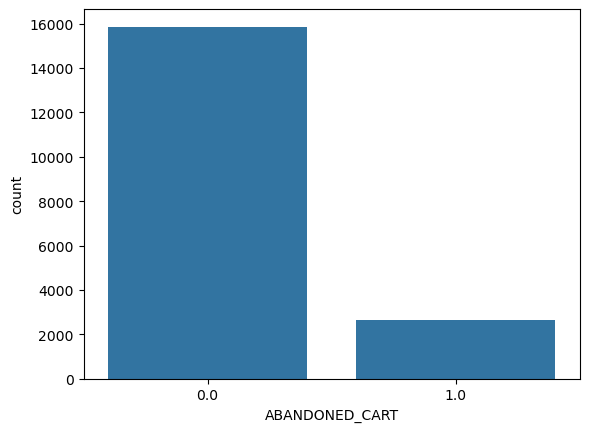

In [23]:
windows_with_ga3 = windows_with_ga2.copy()

# New abandon rate?
print(f"New abandonment rate is {windows_with_ga3['ABANDONED_CART'].mean():.4f}")

sns.countplot(data=windows_with_ga3, x='ABANDONED_CART')
plt.show()

In [24]:
windows_with_ga3.columns.isna().sum()

0

In [25]:
# Split the data
x = windows_with_ga3.drop(columns=['ABANDONED_CART','CUSTOMER_ID'])
y = windows_with_ga3['ABANDONED_CART']

x = x.replace({pd.NA: np.nan})

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=12345,
    stratify=y  # keeps same balance of 0/1 in train and test
)



## Logistic model

In [26]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

# ===== 0) Copy & set target =====
df = windows_with_ga3.copy()

# Ensure binary 0/1
if df['ABANDONED_CART'].dtype != 'int64' and df['ABANDONED_CART'].dtype != 'int32':
    df['ABANDONED_CART'] = df['ABANDONED_CART'].astype('int64')

target_col = 'ABANDONED_CART'
y = df[target_col]

# Optional: drop exact-duplicate rows on features to speed up
# df = df.drop_duplicates()

# ===== 1) Convert time types to numeric =====
for c in df.columns:
    if c == target_col:
        continue
    if pd.api.types.is_datetime64_any_dtype(df[c]):
        df[c] = pd.to_datetime(df[c], errors='coerce').view('int64') / 1e9
    elif pd.api.types.is_timedelta64_dtype(df[c]):
        df[c] = pd.to_timedelta(df[c], errors='coerce').view('int64') / 1e9

# ===== 2) Feature list (exclude target and constants) =====
feature_cols = [c for c in df.columns if c != target_col]
feature_cols = [c for c in feature_cols if df[c].nunique(dropna=False) > 1 and not df[c].equals(df[target_col])]

# (Optional) drop columns with the target name embedded (super conservative)
auto_drop_like_target = [c for c in feature_cols if 'abandoned_cart' in c.lower()]
feature_cols = [c for c in feature_cols if c not in auto_drop_like_target]

# ===== 3) Per-column leakage probes =====
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for col in feature_cols:
    X = df[[col]]

    # Choose transformer by dtype
    if pd.api.types.is_numeric_dtype(X[col]):
        pre = ColumnTransformer([('num', SimpleImputer(strategy='median'), [col])], remainder='drop')
    else:
        pre = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), [col])], remainder='drop')

    model = Pipeline([
        ('prep', pre),
        ('clf', LogisticRegression(max_iter=500, solver='liblinear'))
    ])

    # CV AUC with single feature
    try:
        auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    except Exception:
        auc = np.nan

    # Deterministic/near-deterministic checks
    uniq_0 = df.loc[y == 0, col].nunique(dropna=False)
    uniq_1 = df.loc[y == 1, col].nunique(dropna=False)
    miss_0 = df.loc[y == 0, col].isna().mean()
    miss_1 = df.loc[y == 1, col].isna().mean()
    miss_gap = abs(miss_0 - miss_1)

    # Name-based future-info hints
    name = col.lower()
    name_flag = any(k in name for k in [
        'after','post','future','success','refund','purchase','order','invoice',
        'paid','recentpayed','ordersuccess','postcutoff','window_end','end_to',
        'minutes_of_first_event_and_window_end'
    ])

    # Risk score
    risk = 0
    if pd.notna(auc) and auc >= 0.95: risk += 2
    elif pd.notna(auc) and auc >= 0.90: risk += 1
    if uniq_0 == 1 or uniq_1 == 1: risk += 2
    if miss_gap >= 0.95: risk += 1
    if name_flag: risk += 1

    results.append({
        'column': col,
        'dtype': str(df[col].dtype),
        'auc_single_feature': auc,
        'unique_in_y0': uniq_0,
        'unique_in_y1': uniq_1,
        'missing_rate_y0': round(miss_0, 4),
        'missing_rate_y1': round(miss_1, 4),
        'missing_gap': round(miss_gap, 4),
        'name_flag_future_info': name_flag,
        'leakage_risk_score': risk
    })

leak_report = pd.DataFrame(results).sort_values(
    by=['leakage_risk_score','auc_single_feature'], ascending=[False, False]
).reset_index(drop=True)

# ===== 4) Helpful slices =====
hard_leaks = leak_report[
    (leak_report['auc_single_feature'] >= 0.99) |
    (leak_report['unique_in_y0'].eq(1)) |
    (leak_report['unique_in_y1'].eq(1))
].copy()

suspicious = leak_report[
    (leak_report['leakage_risk_score'] >= 2) | 
    (leak_report['name_flag_future_info'])
].copy()

print("=== Top 25 by risk ===")
display(leak_report.head(25))

print("\n=== Potential HARD leaks (near-perfect signals) ===")
display(hard_leaks.head(25))

print("\n=== Suspicious (score >= 2 or future-info name) ===")
display(suspicious.head(50))

print("\nDropped by name for auto-safety (contains 'abandoned_cart'):")
print(auto_drop_like_target)


/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_47573/50178663.py:29: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[c] = pd.to_datetime(df[c], errors='coerce').view('int64') / 1e9
/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_47573/50178663.py:29: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[c] = pd.to_datetime(df[c], errors='coerce').view('int64') / 1e9
/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_47573/50178663.py:29: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df[c] = pd.to_datetime(df[c], errors='coerce').view('int64') / 1e9


=== Top 25 by risk ===


,column,dtype,auc_single_feature,unique_in_y0,unique_in_y1,missing_rate_y0,missing_rate_y1,missing_gap,name_flag_future_info,leakage_risk_score
0,visited_order,int64,0.539604,2,2,0.0,0.0,0.0,True,1
1,order_page_views,int64,0.537059,53,35,0.0,0.0,0.0,True,1
2,WINDOW_END_LOCAL,float64,0.525941,1427,771,0.0,0.0,0.0,True,1
3,minutes_of_first_event_and_window_end,float64,0.479879,15848,2654,0.0,0.0,0.0,True,1
4,total_events,int64,0.594983,92,61,0.0,0.0,0.0,False,0
5,duration_min_max_event_by_cutoff_minutes,float64,0.574720,15435,2241,0.0,0.0,0.0,False,0
6,add_to_cart_before_event_cutoff_count,int64,0.559707,84,55,0.0,0.0,0.0,False,0
7,SALES_OFFICE,object,0.544776,42,42,0.0,0.0,0.0,False,0
8,remove_from_cart_before_event_cutoff_count,int64,0.540774,36,30,0.0,0.0,0.0,False,0
9,DISTRIBUTION_MODE_DESC,object,0.538868,9,6,0.0,0.0,0.0,False,0



=== Potential HARD leaks (near-perfect signals) ===


,column,dtype,auc_single_feature,unique_in_y0,unique_in_y1,missing_rate_y0,missing_rate_y1,missing_gap,name_flag_future_info,leakage_risk_score



=== Suspicious (score >= 2 or future-info name) ===


,column,dtype,auc_single_feature,unique_in_y0,unique_in_y1,missing_rate_y0,missing_rate_y1,missing_gap,name_flag_future_info,leakage_risk_score
0,visited_order,int64,0.539604,2,2,0.0,0.0,0.0,True,1
1,order_page_views,int64,0.537059,53,35,0.0,0.0,0.0,True,1
2,WINDOW_END_LOCAL,float64,0.525941,1427,771,0.0,0.0,0.0,True,1
3,minutes_of_first_event_and_window_end,float64,0.479879,15848,2654,0.0,0.0,0.0,True,1



Dropped by name for auto-safety (contains 'abandoned_cart'):
[]


In [27]:
# ===== 1) Convert time-like columns to human units (hours/days) =====
# Work on copies to avoid SettingWithCopy warnings
x_train = x_train.copy()
x_test  = x_test.copy()

# Timedelta -> HOURS
td_cols = x_train.select_dtypes(include=['timedelta64[ns]']).columns
for c in td_cols:
    x_train[c] = pd.to_timedelta(x_train[c], errors='coerce').dt.total_seconds() / 3600.0
    x_test[c]  = pd.to_timedelta(x_test[c],  errors='coerce').dt.total_seconds() / 3600.0

# Datetime -> DAYS since an anchor (min train date per column)
dt_cols = x_train.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
for c in dt_cols:
    tr = pd.to_datetime(x_train[c], errors='coerce')
    anchor = tr.min()
    x_train[c] = (pd.to_datetime(x_train[c], errors='coerce') - anchor).dt.total_seconds() / 86400.0
    x_test[c]  = (pd.to_datetime(x_test[c],  errors='coerce') - anchor).dt.total_seconds() / 86400.0

# ===== 2) Build simple pipeline (no standardization) =====
num_cols = x_train.select_dtypes(include=[np.number]).columns
cat_cols = x_train.select_dtypes(include=['object','category','bool']).columns

pipeline = Pipeline(steps=[
    ("prep", ColumnTransformer(transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", drop="first"))
        ]), cat_cols),
    ])),
    # C > 1 reduces regularization -> easier-to-see coefficients
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear", C=10.0))
])

# ===== 3) Fit & evaluate =====
pipeline.fit(x_train, y_train)

y_pred  = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))



Test Accuracy: 0.9011612206319201
Test AUC: 0.8247602016704545
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      3172
         1.0       0.72      0.51      0.60       531

    accuracy                           0.90      3703
   macro avg       0.82      0.74      0.77      3703
weighted avg       0.89      0.90      0.89      3703



/opt/anaconda3/envs/msba/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/msba/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


=== Confusion Matrix (Counts) ===
[[3065  107]
 [ 259  272]]
True Negatives (TN): 3065
False Positives (FP): 107
False Negatives (FN): 259
True Positives (TP): 272

=== Confusion Matrix (Proportions by Row) ===
[[0.966 0.034]
 [0.488 0.512]]


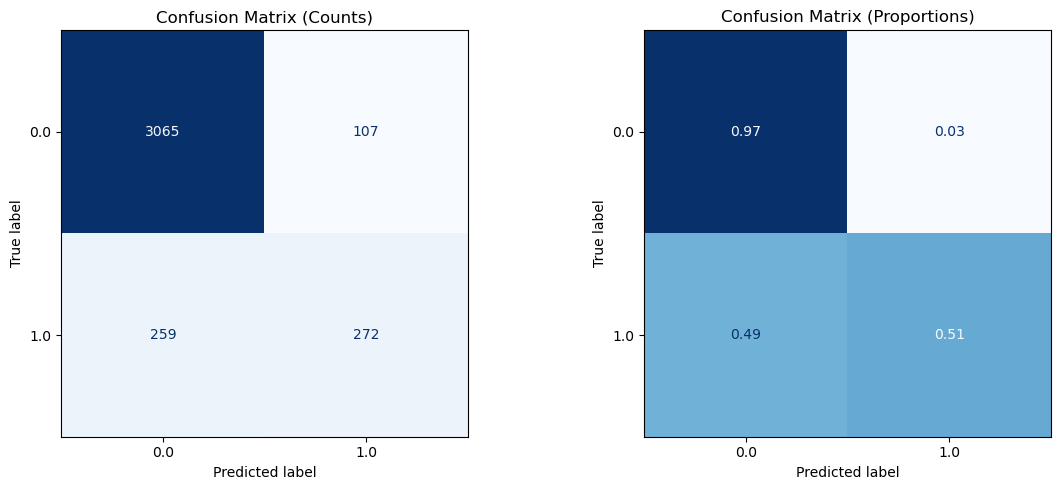


=== Key Metrics ===
Accuracy : 0.901
Precision: 0.718
Recall   : 0.512
F1 Score : 0.598


In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Compute confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("=== Confusion Matrix (Counts) ===")
print(cm)
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# 2️⃣ Compute normalized (proportion per true class)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

print("\n=== Confusion Matrix (Proportions by Row) ===")
print(np.round(cm_norm, 3))

# 3️⃣ Display side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Raw counts
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
axes[0].set_title("Confusion Matrix (Counts)")

# Right: Normalized proportions
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=pipeline.classes_)
disp2.plot(ax=axes[1], cmap='Blues', values_format='.2f', colorbar=False)
axes[1].set_title("Confusion Matrix (Proportions)")

plt.tight_layout()
plt.show()

# 4️⃣ (Optional) Print metrics for reference
print("\n=== Key Metrics ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.3f}")


In [29]:
# ===== 4) Coefficients + Odds Ratios (interpretable) =====
pre = pipeline.named_steps["prep"]
clf = pipeline.named_steps["clf"]

# Feature names from ColumnTransformer (sklearn >= 1.0)
try:
    feature_names = pre.get_feature_names_out()
except AttributeError:
    # Fallback for older sklearn
    from sklearn.utils._metadata_requests import _safe_get_feature_names_out
    feature_names = _safe_get_feature_names_out(pre, input_features=x_train.columns)

coefs = clf.coef_[0]

coef_table = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
})
coef_table["odds_ratio"] = np.exp(coef_table["coef"])             # per +1 unit
coef_table["odds_ratio_per_10"] = np.exp(10 * coef_table["coef"]) # per +10 units (helpful for time features)
coef_table["abs_coef"] = coef_table["coef"].abs()

# Sort by influence
coef_table = coef_table.sort_values("abs_coef", ascending=False)

# Pretty display
with pd.option_context('display.float_format', '{:.8f}'.format,
                       'display.max_rows', None,
                       'display.max_colwidth', 120):
    display(coef_table.head(30))



,feature,coef,odds_ratio,odds_ratio_per_10,abs_coef
6,num__remove_from_cart_before_event_cutoff_count,2.66192709,14.32386583,363582059159.76586914,2.66192709
12,num__total_events,-2.64177250,0.07123489,0.00000000,2.64177250
5,num__add_to_cart_before_event_cutoff_count,2.60487045,13.52947246,205498488138.89727783,2.60487045
75,cat__DISTRIBUTION_MODE_DESC_Sideload,0.34861228,1.41709965,32.65907631,0.34861228
18,num__visited_order,-0.29918601,0.74142149,0.05019399,0.29918601
43,cat__SALES_OFFICE_G235,0.22671037,1.25446648,9.65140682,0.22671037
22,cat__SALES_OFFICE_G121,-0.18071574,0.83467259,0.16412001,0.18071574
54,cat__SALES_OFFICE_G281,0.17136020,1.18691820,5.54891286,0.17136020
47,cat__SALES_OFFICE_G261,0.15844252,1.17168457,4.87648739,0.15844252
92,cat__TIMEZONE_America/Los_Angeles,0.15665430,1.16959121,4.79006017,0.15665430
